## Table of contents
* [Define parameters](#parameters)
* [Download and prepare input data](#prepare)
* [Evaluate predictions using Rhea reactions with curated EC](#curatedEC)
* [Evaluate predictions using Rhea reactions with inferred EC](#inferredEC)
    * [Infer EC classes from curated Rhea reaction hierarchy](#hierarchy)
    * [Compare hierarchy-inferred and predicted ECs](#compare)
    * [Plot MLP probabilities](#plot)

In [1]:
import pandas as pd

## Define parameters <a class="anchor" id="parameters"></a>

In step 3 we have used the <code>ec123_drfp_mlp</code> model to make EC predictions. Here we will evaluate them.

In [2]:
modeltype='ec123_drfp_mlp'

## Download and prepare input data <a class="anchor" id="prepare"></a>

Download the input files from the Rhea FTP site https://ftp.expasy.org/databases/rhea/tsv/ (internet connection required) and pre-process them.

In [3]:
# Get input data.
df_ec        = pd.read_csv('https://ftp.expasy.org/databases/rhea/tsv/rhea2ec.tsv', sep='\t')
df_hierarchy = pd.read_csv('https://ftp.expasy.org/databases/rhea/tsv/rhea-relationships.tsv', sep='\t')
df_quartet   = pd.read_csv('https://ftp.expasy.org/databases/rhea/tsv/rhea-directions.tsv', sep='\t')
df_pred      = pd.read_csv(f'experiments/predictions/rheadb_predicted_ECs_{modeltype}.tsv', sep='\t')

print('df_ec = File rhea2ec.tsv \(curated ECs\)')
print('  ', df_ec.columns)
print('  ', len(df_ec), 'reaction - curated EC pairs')
print('df_hierarchy = rhea-relationships.tsv \(curated reaction hierarchy\)')
print('  ', df_hierarchy.columns)
print('  ', len(df_hierarchy), 'reaction relationships')
print('df_quartet = File rhea-directions.tsv \(reaction quartets\)')
print('  ', df_quartet.columns)
print('  ', len(df_quartet), 'reaction quartets')

print('\n=> Cleaning predictions file.\n')
print('df_pred = experiments/predictions/rheadb_predicted_ECs_{modeltype}.tsv')
print('  ', df_pred.columns)
print('  ', len(df_pred), 'rows')

print('\n-> Removing reactions without a prediction (i.e. those without a reaction SMILES).\n')
df_pred = df_pred[df_pred['EC_prediction']!='No prediction']
print('df_pred after removal of reactions without reaction SMILES')
print('  ', len(df_pred), 'rows')

# We tried to predict an EC for the forward and reverse reaction direction.
# Here we remove duplications. 
print('\n-> Removing "duplications" (same reaction with different directions).\n')

# Add the ID of the undirected reaction (MASTER_ID) to the directed reactions
# (RHEA_ID_LR or RHEA_ID_RL) to identify the "duplicates".
def findMasterID(row):
    if not pd.isna(row['MASTER_ID']):
        return int(row['MASTER_ID'])
    if df_quartet.loc[df_quartet['RHEA_ID_LR'] == row['rhea_id']]['RHEA_ID_MASTER'].to_list():
        return df_quartet.loc[df_quartet['RHEA_ID_LR'] == row['rhea_id']]['RHEA_ID_MASTER'].to_list()[0]
    if df_quartet.loc[df_quartet['RHEA_ID_RL'] == row['rhea_id']]['RHEA_ID_MASTER'].to_list():
        return df_quartet.loc[df_quartet['RHEA_ID_RL'] == row['rhea_id']]['RHEA_ID_MASTER'].to_list()[0]
    # None is for obsolete reactions.
    return None
    
df_pred['MASTER_ID_checked'] = df_pred.apply(findMasterID, axis=1)
df_pred = df_pred[~df_pred['MASTER_ID_checked'].isna()]
df_pred.drop(columns=['MASTER_ID'], inplace=True)
df_pred.rename(columns={'MASTER_ID_checked': "MASTER_ID"}, inplace=True)
print('dr_pred after adding MASTER_ID')
print('  ', df_pred.columns)
print('  ', len(df_pred), 'rows')

# Remove "duplications" (same reaction with different directions).
df_pred.drop_duplicates(subset=['MASTER_ID','EC_prediction'], inplace=True)
print('df_pred after removal of "duplications"')
print('  ', len(df_pred), 'reactions with predicted EC')

# Save the processed dataframe.
output = "experiments/predictions/rheadb_predicted_ECs_clean.tsv"
df_pred.to_csv(output, sep='\t', index=False)
print('\n=> Created file', output)

df_ec = File rhea2ec.tsv \(curated ECs\)
   Index(['RHEA_ID', 'DIRECTION', 'MASTER_ID', 'ID'], dtype='object')
   7592 reaction - curated EC pairs
df_hierarchy = rhea-relationships.tsv \(curated reaction hierarchy\)
   Index(['FROM_REACTION_ID', 'TYPE', 'TO_REACTION_ID'], dtype='object')
   15480 reaction relationships
df_quartet = File rhea-directions.tsv \(reaction quartets\)
   Index(['RHEA_ID_MASTER', 'RHEA_ID_LR', 'RHEA_ID_RL', 'RHEA_ID_BI'], dtype='object')
   15837 reaction quartets

=> Cleaning predictions file.

df_pred = experiments/predictions/rheadb_predicted_ECs_{modeltype}.tsv
   Index(['MASTER_ID', 'ec', 'rhea_id', 'rxn_smiles', 'EC_prediction'], dtype='object')
   32285 rows

-> Removing reactions without a prediction (i.e. those without a reaction SMILES).

df_pred after removal of reactions without reaction SMILES
   32277 rows

-> Removing "duplications" (same reaction with different directions).

dr_pred after adding MASTER_ID
   Index(['ec', 'rhea_id', 'rxn_smiles'

## Evaluate predictions using Rhea reactions with curated EC <a class="anchor" id="curatedEC"></a>

Evaluation 1: Use Rhea reactions with expert-curated ECs to evaluate the quality of the EC predictions.

These are the reactions that we used to train the models, so we expect very good accuracy.

In [4]:
df_pred_for_curated_ec = df_pred[df_pred['ec'].notna()].copy()
df_pred_for_curated_ec[["ec_1", "ec_2", "ec_3", "ec_4"]] = df_pred_for_curated_ec.ec.astype(str).str.split(".", expand=True)
df_pred_for_curated_ec["ec123"] = ( 
        df_pred_for_curated_ec.ec_1.astype(str) + "." +
        df_pred_for_curated_ec.ec_2.astype(str) + "." + 
        df_pred_for_curated_ec.ec_3.astype(str)
    )
df_pred_for_curated_ec.drop(columns=["ec_2", "ec_3", "ec_4"], inplace=True)
df_pred_for_curated_ec['best_pred_EC'] =  df_pred_for_curated_ec.apply(
                 lambda x: x["EC_prediction"].split(' | ')[0].split(':')[0], axis=1)
df_pred_for_curated_ec['match'] = df_pred_for_curated_ec.apply(lambda x: x['best_pred_EC'] == x['ec123'], axis=1)
df_pred_for_curated_ec.sort_values(by=['match', 'ec_1'], inplace=True)
df_pred_for_curated_ec.to_csv("experiments/predictions/rheadb_predicted_ECs_for_curated_EC_clean.tsv", sep='\t', index=False)

df_pred_for_curated_ec['best_pred_EC'] = df_pred_for_curated_ec.apply(
                 lambda x: x["EC_prediction"].split(' | ')[0].split(':')[0], axis=1)

df_pred_for_curated_ec['best_pred_EC_probability'] = df_pred_for_curated_ec.apply( 
                 lambda x: float(x["EC_prediction"].split(" | ")[0].split(":")[1]), axis=1)

print('\nTotal:\n')

print(len(df_pred_for_curated_ec), 'reactions with curated and predicted EC')

df_ec_true  = df_pred_for_curated_ec.loc[(df_pred_for_curated_ec.match == True)]
print(len(df_ec_true), 'true predictions')

df_ec_false = df_pred_for_curated_ec.loc[(df_pred_for_curated_ec.match == False)]
print(len(df_ec_false), 'false predictions')

print('\nWith probability > 0.9:\n')

df_ec_total = df_pred_for_curated_ec.loc[
    (df_pred_for_curated_ec.best_pred_EC_probability>0.9)]
print(len(df_ec_total), 'reactions with curated and predicted EC')

df_ec_true  = df_pred_for_curated_ec.loc[
    (df_pred_for_curated_ec.best_pred_EC_probability>0.9) &
    (df_pred_for_curated_ec.match == True)]
print(len(df_ec_true), 'true predictions')

df_ec_false = df_pred_for_curated_ec.loc[
    (df_pred_for_curated_ec.best_pred_EC_probability>0.9) &
    (df_pred_for_curated_ec.match == False)]
print(len(df_ec_false), 'false predictions')


Total:

7303 reactions with curated and predicted EC
6945 true predictions
358 false predictions

With probability > 0.9:

6669 reactions with curated and predicted EC
6624 true predictions
45 false predictions


## Evaluate predictions using Rhea reactions with hierarchy-inferred EC <a class="anchor" id="inferredEC"></a>

Evaluation 2: Use the curated Rhea reaction hierarchy to infer ECs for related reactions to evaluate the quality of the EC predictions against data that was not used for training the models.

In [5]:
df_pred_for_lacking_ec = df_pred[df_pred['ec'].isna()].copy()
print(len(df_pred_for_lacking_ec), 'reactions without curated EC')

8524 reactions without curated EC


### Infer EC classes from curated Rhea reaction hierarchy <a class="anchor" id="hierarchy"></a>

In [6]:
import networkx as nx
G = nx.from_pandas_edgelist(df_hierarchy, 'FROM_REACTION_ID', 'TO_REACTION_ID')
ec_dict = pd.Series(df_ec.ID.values,index=df_ec.MASTER_ID).to_dict()
nx.set_node_attributes(G, ec_dict, name="ec")
f_out = open("experiments/predictions/rheadb_components_inferred_EC.tsv", 'w')
f_out.write("RHEA_ID\tcomponent_id\tcommon_ec\n")
for ind, component in enumerate(nx.connected_components(G)):
    common_3l_ec_list = []
    H = nx.induced_subgraph(G, component)
    all_nodes = list(H.nodes(data=True))
    for node in all_nodes:
        common_3l_ec_list.append('.'.join(node[1].get('ec', '...').split('.')[:3]))
    common_ecs_of_family = ' | '.join(list(set(common_3l_ec_list) - {'..'}))
    for node in component:
        f_out.write(f'{node}\t{ind+1}\t{common_ecs_of_family}\n')
f_out.close()

df_components = pd.read_csv("experiments/predictions/rheadb_components_inferred_EC.tsv", sep='\t')
print('df_components = rhea reactions grouped according to hierarchy, with their EC(s)')
print(df_components.columns)
df_components.dropna(inplace=True)

# Print number of inferred EC classes and reactions with inferred EC classes.
ecs = []
for ecs_group in df_components['common_ec'].unique():
    if type(ecs_group) == str:
        ecs.extend(ecs_group.split(' | '))
print()
print(len(set(ecs)), 'distinct inferred EC (3-level)')
print(len(df_components), 'reactions with inferred EC (3-level)')

df_components = rhea reactions grouped according to hierarchy, with their EC(s)
Index(['RHEA_ID', 'component_id', 'common_ec'], dtype='object')

114 distinct inferred EC (3-level)
3696 reactions with inferred EC (3-level)


### Compare hierarchy-inferred and predicted ECs <a class="anchor" id="compare"></a>

In [7]:
def getMatchInferredAndPredicted(row):
    if not pd.isna(row['common_ec']):
        if row['best_pred_EC'] in row['common_ec'].split(' | '):
            return True
        return False
    return ""

df_pred_for_lacking_ec['best_pred_EC'] =  df_pred_for_lacking_ec.apply(
                 lambda x: x["EC_prediction"].split(' | ')[0].split(':')[0], axis=1)

df_pred_for_lacking_ec['best_pred_EC_probability'] =  df_pred_for_lacking_ec.apply( 
                 lambda x: float(f'{float(x["EC_prediction"].split(" | ")[0].split(":")[1]):.3f}'), axis=1)


df_pred_for_lacking_ec_with_components = df_pred_for_lacking_ec.merge(df_components, 
                                             how = "left", left_on = "MASTER_ID", right_on = "RHEA_ID")

df_pred_for_lacking_ec_with_components.drop(columns=['ec', 'RHEA_ID'], inplace=True)
df_pred_for_lacking_ec_with_components.sort_values(by=['component_id'], inplace=True)
df_pred_for_lacking_ec_with_components['match_hierarchy_and_prediction'] \
                  = df_pred_for_lacking_ec_with_components.apply(getMatchInferredAndPredicted, axis=1)

print('\nTotal:\n')

df_ec_total = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction != '')]
print(len(df_ec_total), 'reactions with inferred and predicted EC')

df_ec_true = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction == True)]
print(len(df_ec_true), 'true predictions')

df_ec_false = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction == False)]
print(len(df_ec_false), 'false predictions')

print('\nWith probability > 0.9:\n')

df_ec_total = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.best_pred_EC_probability>0.9) &
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction != '')]
print(len(df_ec_total), 'reactions with inferred and predicted EC')

df_ec_true = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.best_pred_EC_probability>0.9) &
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction == True)]
print(len(df_ec_true), 'true predictions')

df_ec_false = df_pred_for_lacking_ec_with_components.loc[
    (df_pred_for_lacking_ec_with_components.best_pred_EC_probability>0.9) &
    (df_pred_for_lacking_ec_with_components.match_hierarchy_and_prediction == False)]
print(len(df_ec_false), 'false predictions')


Total:

2115 reactions with inferred and predicted EC
2000 true predictions
115 false predictions

With probability > 0.9:

1836 reactions with inferred and predicted EC
1815 true predictions
21 false predictions


### Plot MLP probabilities <a class="anchor" id="plot"></a>

Plot MLP probabilities for EC predictions
- that match the hierarchy-inferred ECs
- that differ from the hierarchy-inferred ECs
- where no hierarchy-inferred ECs are available

In [8]:
import matplotlib.pyplot as plt

def plotProbs(df, func, label):
    binwidth = 10
    df_1 = df[func(df['match_hierarchy_and_prediction'])].copy()
    probs = df_1.best_pred_EC_probability.astype('float').apply(lambda x: x*100)
    probs.hist(bins=range(0, 110, binwidth))
    plt.title(label)
    plt.ylabel('Number of reactions')
    plt.xlim(0,110)
    plt.xlabel('MLP probability (%)')
    plt.savefig('figures/'+label+'.png')

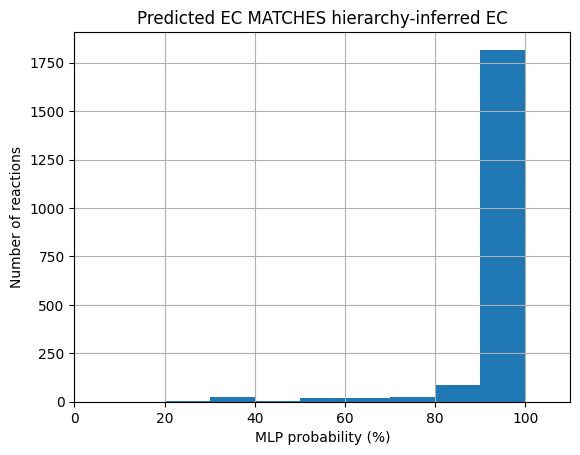

In [9]:
plotProbs(df_pred_for_lacking_ec_with_components, lambda x: x==True,
          "Predicted EC MATCHES hierarchy-inferred EC")

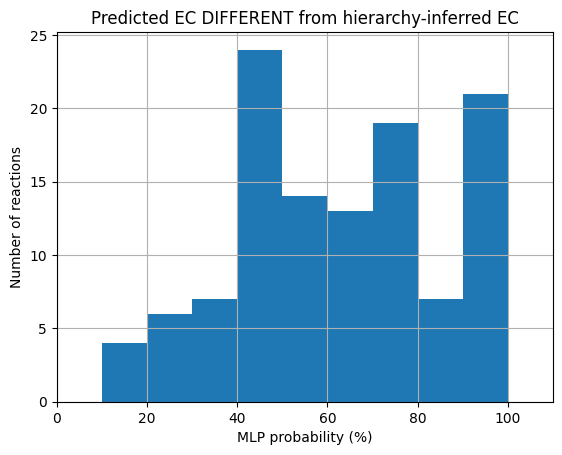

In [10]:
plotProbs(df_pred_for_lacking_ec_with_components, lambda x: x==False,
          "Predicted EC DIFFERENT from hierarchy-inferred EC")

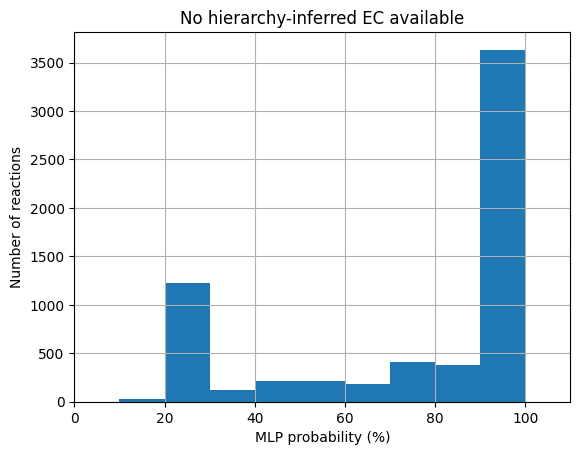

In [11]:
plotProbs(df_pred_for_lacking_ec_with_components, lambda x: x=='',
          "No hierarchy-inferred EC available")